In [229]:
import numpy as np
import scipy
import scipy.signal
import scipy.io.wavfile as wf


class SpeechActivityDetection():

    def __init__(self, wave_input_filename):
        self.rate, self.data = wf.read(wave_input_filename)

    def get_audio(self):
        return self.data

    def get_rate(self):
        return self.rate

    def get_data(self):
        return self.data, self.rate
    
    def get_energy(self):
        return self.energy
    
    def get_vad(self):
        return self.vad
    
    def get_voice(self):
        return self.voice

    def detect_speech(self):
        energy, vad, voice = self.calculate_energy_and_split_voice_and_no_voice()
        self.energy = energy
        self.vad = vad
        self.voice = voice
        voice_peaks,_ = scipy.signal.find_peaks(voice, distance=20000)
        return voice_peaks

    def _stride_trick(self, data, stride_length, stride_step):
        nrows = ((data.size - stride_length) // stride_step) + 1
        n = data.strides[0]
        return np.lib.stride_tricks.as_strided(data,
                                               shape=(nrows, stride_length),
                                               strides=(stride_step*n, n))

    def _get_frames(self, window_len=0.015, window_hop=0.015):

        if window_len < window_hop: raise Exception('Window hop can not be bigger that window length.')

        # seconds to frames
        frame_length = window_len * self.rate
        frame_step = window_hop * self.rate
        signal_length = len(self.data)
        frames_overlap = frame_length - frame_step

        rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
        pad_signal = np.append(self.data, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))
        frames = self._stride_trick(pad_signal, int(frame_length), int(frame_step))
        return frames, frame_length

    def short_time_energy(self, frames):
        return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2

    def calculate_energy_and_split_voice_and_no_voice(self, threshold=-20, window_len=0.05, window_hop=0.05, E0=1e7):
        frames, frames_len = self._get_frames(window_len=window_len, window_hop=window_hop)
        energy = self.short_time_energy(frames)

        log_energy = 10 * np.log10(energy / E0)

        # normalize
        energy = scipy.signal.medfilt(log_energy, 5)
        energy[energy <= -1E20] = 0 # avoid - Inf numbers
        energy = np.repeat(energy, frames_len)

        threshold_1 = np.mean(energy) - np.mean(energy)* 0.08 
        threshold_2 = np.mean(energy) - np.mean(energy)* 0.05 
        threshold_3 = np.mean(energy) + np.mean(energy)* 0.05
        threshold_4 = np.mean(energy) + np.mean(energy)* 0.08
        threshold_5  = np.average(energy)
        
        print(f"avg = {threshold_1}")
        print(f"avg = {threshold_2}")
        print(f"avg = {threshold_3}")
        print(f"avg = {threshold_4}")
        print(f"avg = {threshold_5}")
        
        voice_activity_detection_1     = np.array(energy > threshold_1, dtype=self.data.dtype)
        voice_activity_detection_2     = np.array(energy > threshold_2, dtype=self.data.dtype)
        voice_activity_detection_3     = np.array(energy > threshold_3, dtype=self.data.dtype)
        voice_activity_detection_4     = np.array(energy > threshold_4, dtype=self.data.dtype)
        voice_activity_detection_5     = np.array(energy > threshold_5, dtype=self.data.dtype)
        
        vframes_1 = np.array(frames.flatten()[np.where(voice_activity_detection_1==1)], dtype=self.data.dtype)
        vframes_2 = np.array(frames.flatten()[np.where(voice_activity_detection_2==1)], dtype=self.data.dtype)
        vframes_3 = np.array(frames.flatten()[np.where(voice_activity_detection_3==1)], dtype=self.data.dtype)
        vframes_4 = np.array(frames.flatten()[np.where(voice_activity_detection_4==1)], dtype=self.data.dtype)
        vframes_5 = np.array(frames.flatten()[np.where(voice_activity_detection_5==1)], dtype=self.data.dtype)
        print(len(vframes_1))
        print(len(vframes_2))
        print(len(vframes_3))
        print(len(vframes_4))
        print(len(vframes_5))
        voice_activity_detection = None
        vframes = None
        if len(vframes_1) > len(vframes_2) and len(vframes_1) > len(vframes_3) and len(vframes_1) > len(vframes_4) and len(vframes_1) > len(vframes_5):
            print("1")
            voice_activity_detection = voice_activity_detection_1
            vframes = vframes_1
        
        if len(vframes_2) > len(vframes_1) and len(vframes_2) > len(vframes_3) and len(vframes_2) > len(vframes_4) and len(vframes_2) > len(vframes_5):
            print("2")
            voice_activity_detection = voice_activity_detection_2
            vframes = vframes_2
        
        if len(vframes_3) > len(vframes_1) and len(vframes_3) > len(vframes_2) and len(vframes_3) > len(vframes_4) and len(vframes_3) > len(vframes_5):
            print("3")
            voice_activity_detection = voice_activity_detection_3
            vframes = vframes_3
        
        if len(vframes_4) > len(vframes_1) and len(vframes_4) > len(vframes_2) and len(vframes_4) > len(vframes_3) and len(vframes_4) > len(vframes_5):
            print("4")
            voice_activity_detection = voice_activity_detection_4
            vframes = vframes_4
        
        if len(vframes_5) > len(vframes_1) and len(vframes_5) > len(vframes_2) and len(vframes_5) > len(vframes_3) and len(vframes_5) > len(vframes_4):
            print("5")
            voice_activity_detection = voice_activity_detection_5
            vframes = vframes_5
        return energy, voice_activity_detection, np.array(vframes, dtype=np.float64)


In [230]:
detection = SpeechActivityDetection("test/16.wav")
signal, rate = detection.get_data()
detection.detect_speech()
energy = detection.get_energy()
vad = detection.get_vad()
voice = detection.get_voice()

avg = 73.79262899503979
avg = 76.19891037531283
avg = 84.21984830955628
avg = 86.62612968982933
avg = 80.20937934243456
496000
475200
336000
256800
427200
1


/Users/adrian/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10


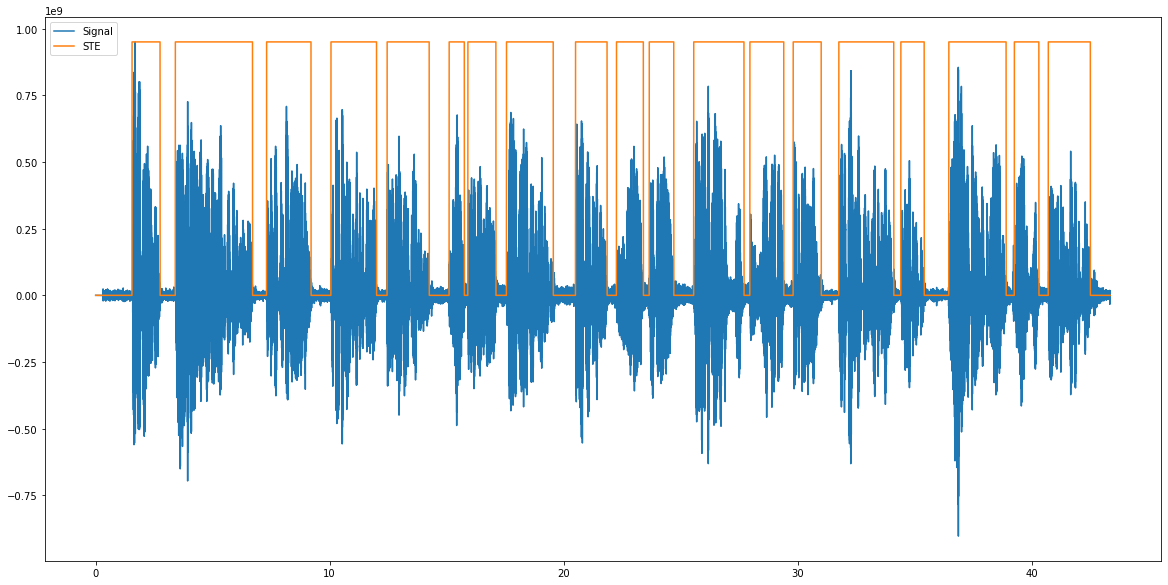

In [231]:
import matplotlib.pyplot as plt


plt.subplots(1, 1, figsize=(20, 10))
plt.plot([i/rate for i in range(len(signal))], signal, label="Signal")
plt.plot([i/rate for i in range(len(vad))], max(signal)* vad, label="STE")
plt.legend(loc='best')
plt.show()

In [232]:
s = max(signal)* vad

In [233]:
sum(s[i - 1] != s[i] for i in range(1, len(s)))

38